
<a href="https://colab.research.google.com/github/lmanov1/CancerPrediction/blob/main/DataCleansing.ipynb" target="_blank">         
<img src="https://colab.research.google.com/assets/colab-badge.svg" target="_blank">
</a>

In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# 1. Data Cleansing
This stage include handling outliers and missing values 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import zscore, ks_2samp

df_cleansing = pd.read_pickle("./EDA_Cancer_Data.pkl")

## 2. Outliers
 

By now it is clear that most of the features are not distibuted normally (but skewed) , so that the methods to use should be those that do not assume normal distribution.    
Let's prepare the data towards outliers tests which include comparisons of distributions and correlations of a data with and without outliers in order to decide if we can remove the above outliers (kolmogorov 2-sample test to measure distribution changes and spearman test to measure correlation changes)     
For this we'll temporarily convert a target (diagnosis) to numerical form  (to 1 and 0, respectively)

In [3]:
df_with_outliers = df_cleansing.copy()
diagnosis_coder = {'M':1, 'B':0}
df_with_outliers.diagnosis = df_with_outliers.diagnosis.map(diagnosis_coder)
display(df_with_outliers.head())
df_with_outliers.info()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### Lets visualize our numeric data with boxplots -before any manipulations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

None

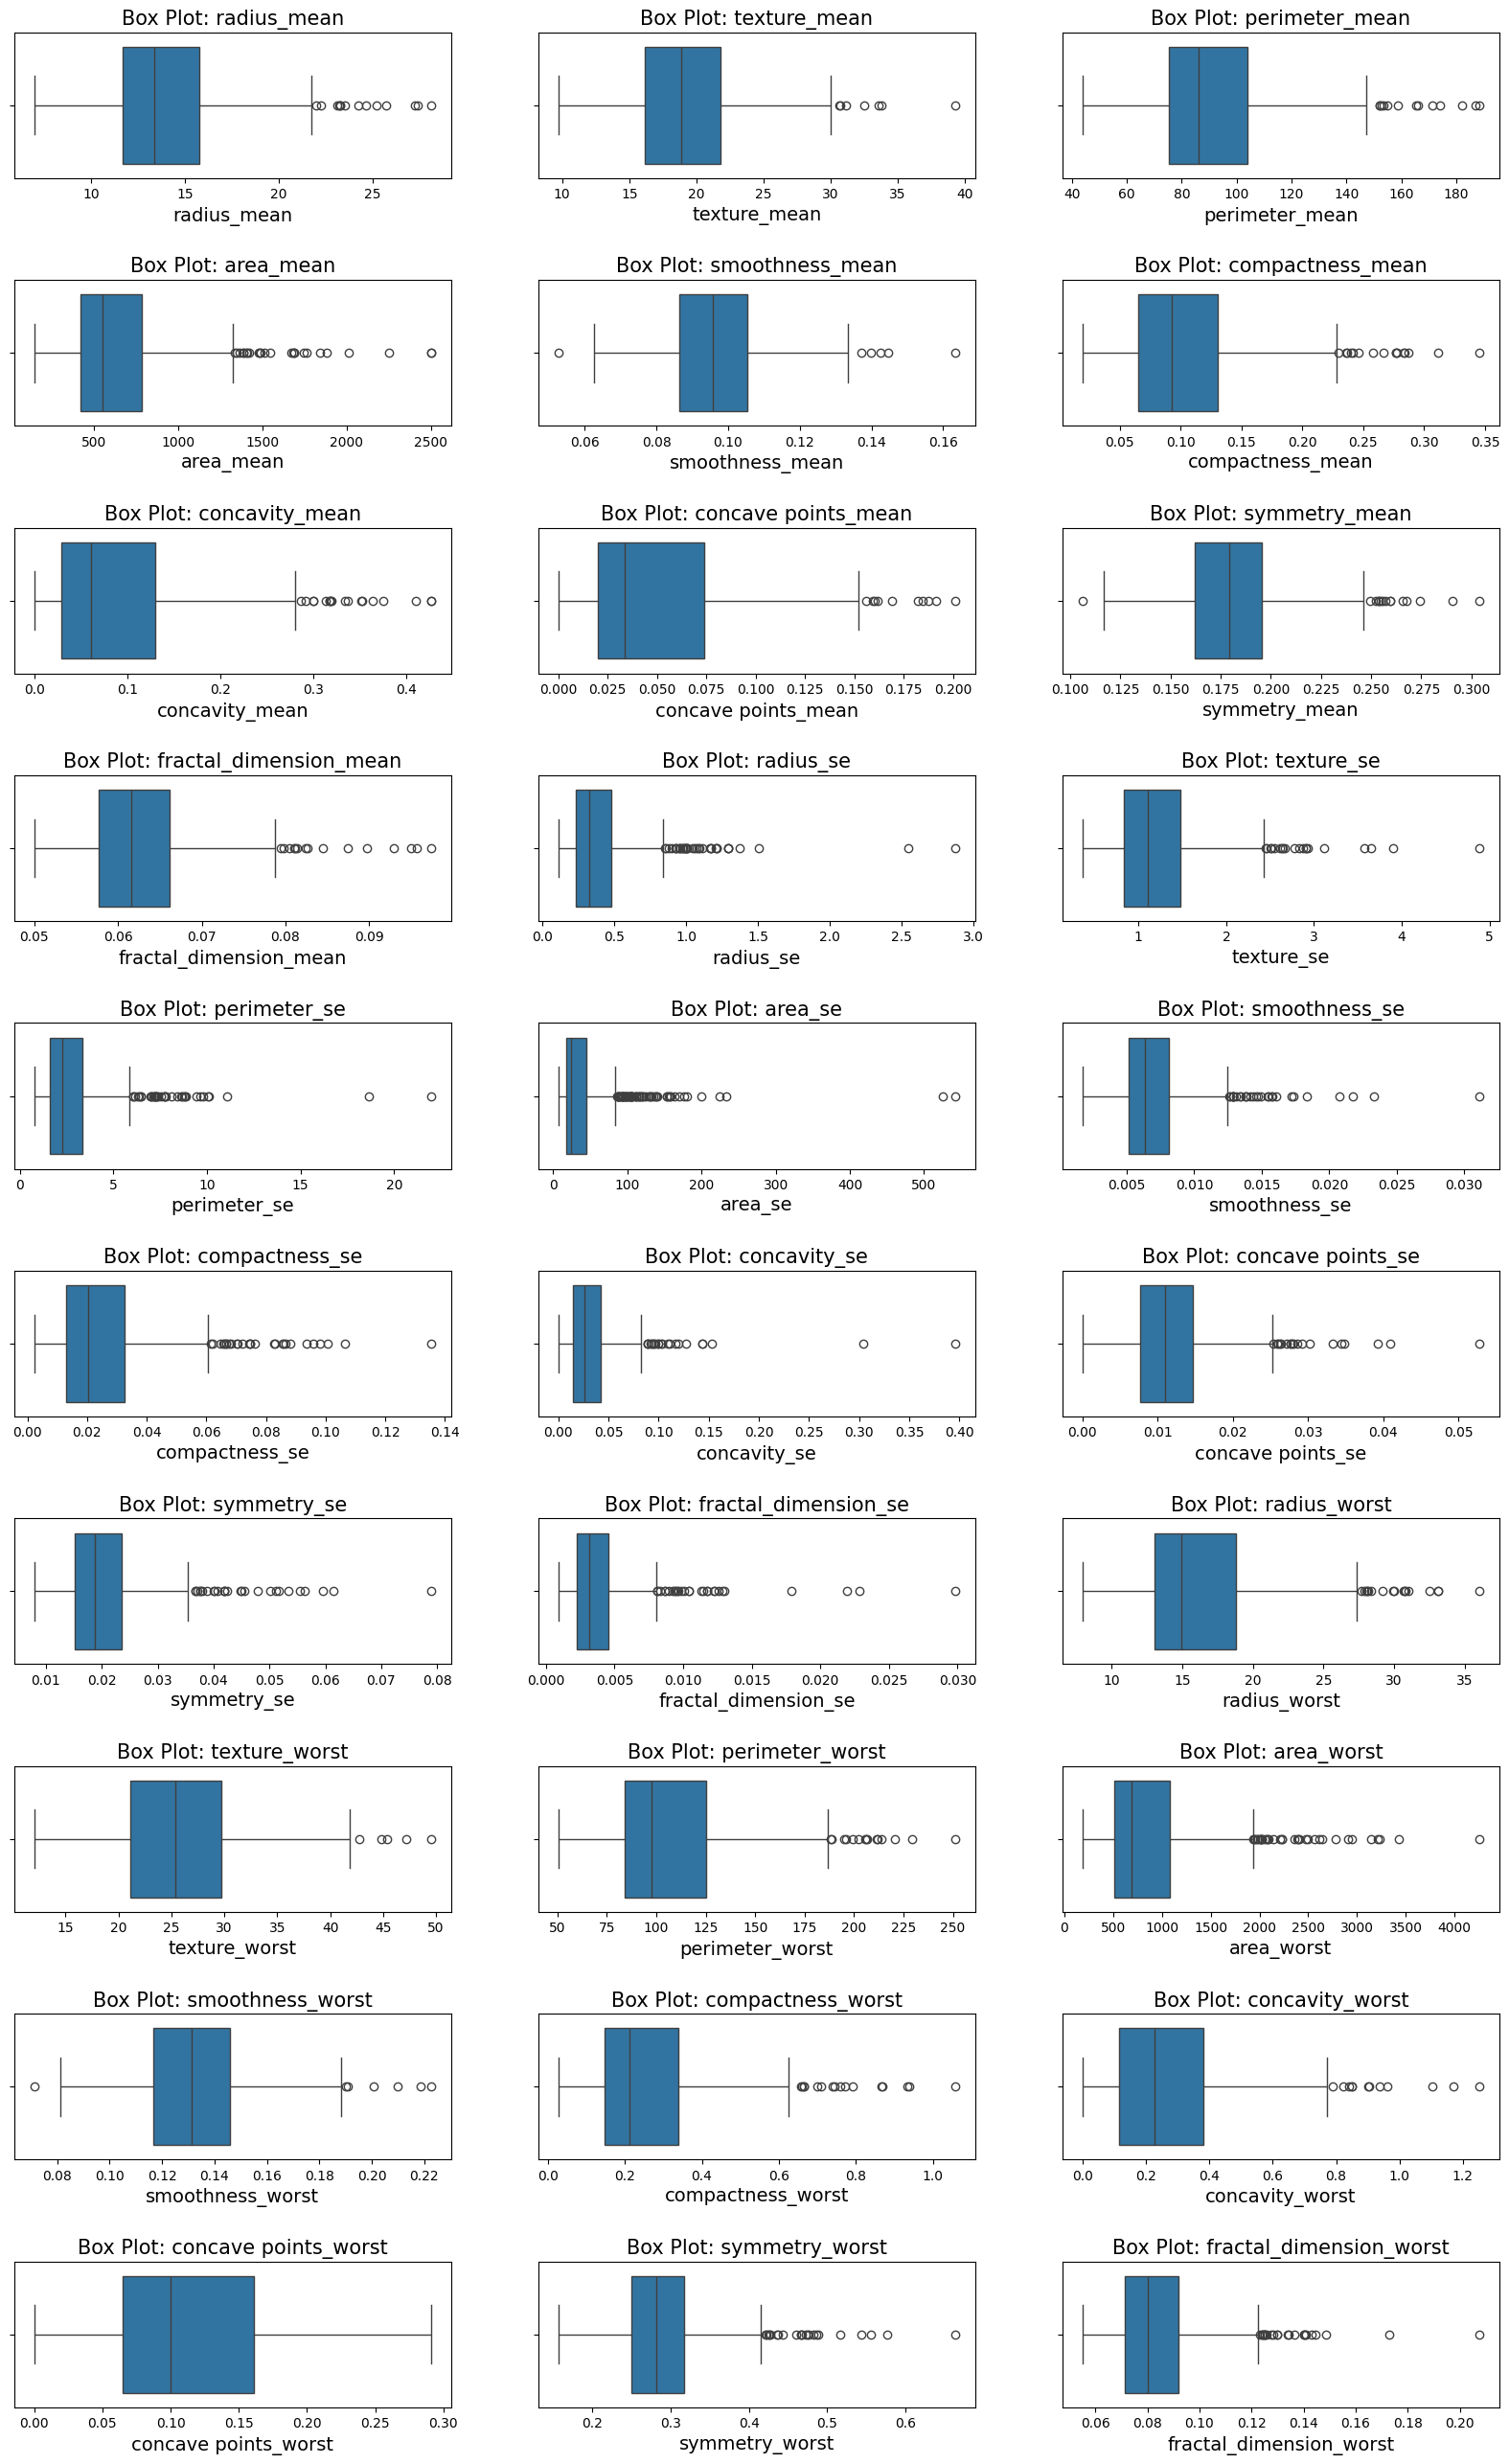

In [4]:
import matplotlib.pyplot as plt
# Define the function to plot box plots for each numeric column
def outliers_boxplot(df):    
    plt.figure(figsize=(20, 200))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(60, 3, i + 1)
        sb.boxplot(data=df, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(f'{col}', fontsize=14)
    plt.subplots_adjust(hspace=0.7)
    plt.show()
numerical_features = df_cleansing.select_dtypes(include=[float])
#.drop(columns='diagnosis')
display(numerical_features.info())
numerical_cols = df_cleansing.select_dtypes(include=[float]).columns
#numerical_cols
outliers_boxplot(numerical_features)


### Code : Detect outliers
* As seen on EDA step (or just above with box plots) , most of numerical data is rigth skewed , so to assess outliers i will use IQR method

In [5]:
display(numerical_features.info())
display(numerical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

None

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [6]:
# Function to identify and treat outliers using IQR
def treat_outliers_iqr(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR        
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)        
    return df_outliers

outliers_df = treat_outliers_iqr(numerical_features,numerical_cols)
display(outliers_df.shape)
# print the number of outliers for each feature , in descending order
display(outliers_df.sum().sort_values(ascending=False))

(569, 30)

area_se                    65
radius_se                  38
perimeter_se               38
area_worst                 35
smoothness_se              30
compactness_se             28
fractal_dimension_se       28
symmetry_se                27
area_mean                  25
fractal_dimension_worst    24
symmetry_worst             23
concavity_se               22
texture_se                 20
concave points_se          19
concavity_mean             18
radius_worst               17
compactness_worst          16
compactness_mean           16
perimeter_worst            15
fractal_dimension_mean     15
symmetry_mean              15
radius_mean                14
perimeter_mean             13
concavity_worst            12
concave points_mean        10
texture_mean                7
smoothness_worst            7
smoothness_mean             6
texture_worst               5
concave points_worst        0
dtype: int64

### Let visualize the differences in correlation/distribution  before and after removing outliers

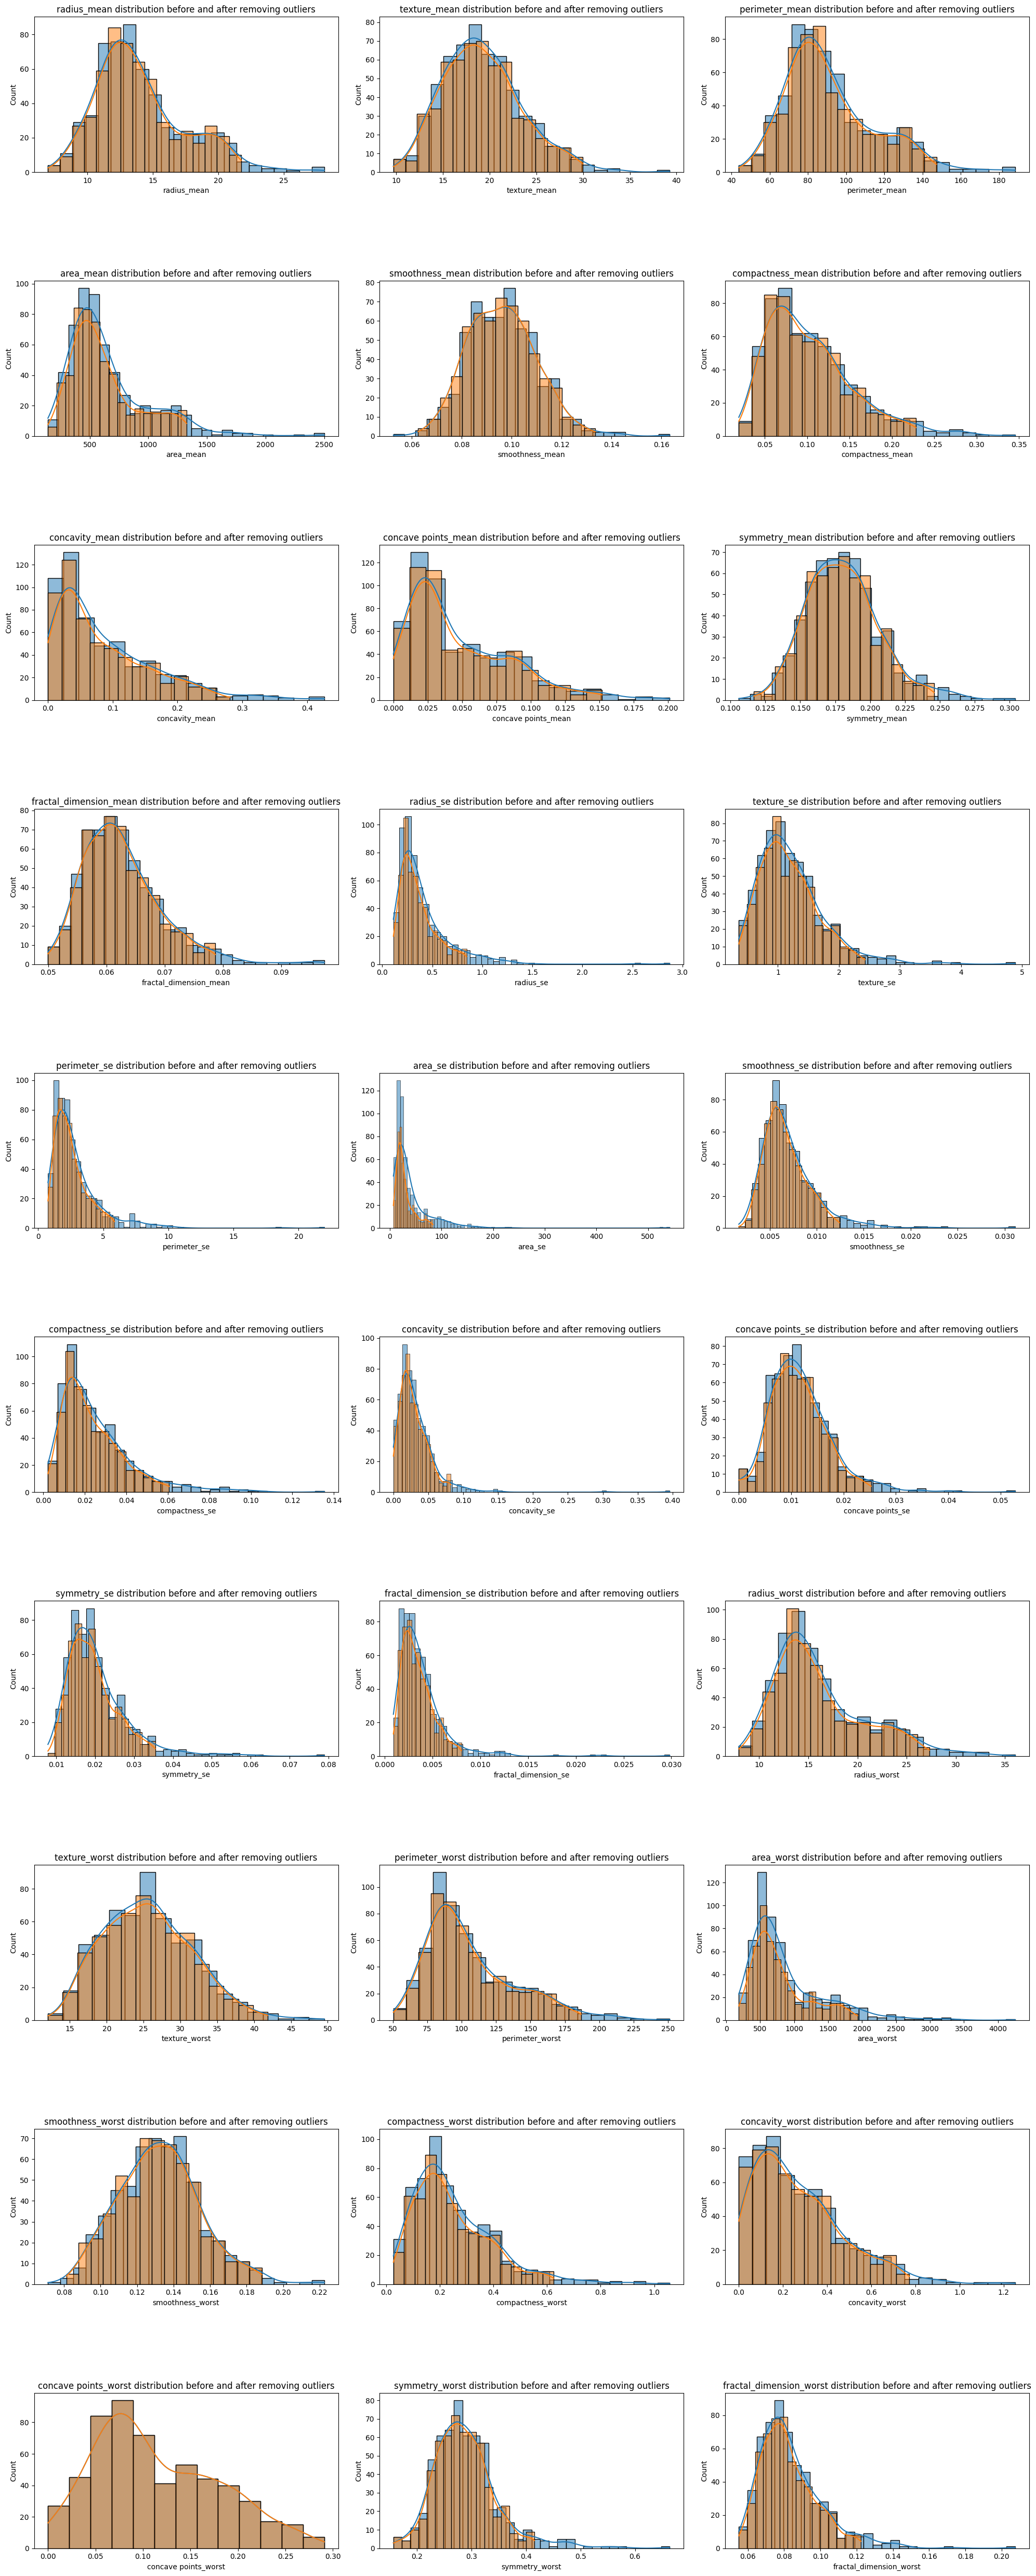

,feature,spearman_corr_before,spearman_corr_after
0,fractal_dimension_worst,0.311477,0.279897
1,symmetry_worst,0.396843,0.344004
2,concave points_worst,0.781674,0.781674
3,concavity_worst,0.705734,0.704137
4,compactness_worst,0.606810,0.581718
5,smoothness_worst,0.425513,0.422941
6,area_worst,0.786902,0.756415
7,perimeter_worst,0.796319,0.785315
8,texture_worst,0.476720,0.466555
9,radius_worst,0.787933,0.774688


In [18]:
# Visualize differences in correlation  before and after removing outliers
from scipy.stats import spearmanr
import seaborn as sns
# Function to calculate IQR and remove outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def visualize_diffs(data , numerical_cols):
    # num_plots = len(numerical_cols) * 2
    # num_rows = len(numerical_cols)
    # num_cols = 2 if num_plots % 2 == 0 else 3
    #fig = plt.figure(figsize=(num_rows, num_cols))
    fig = plt.figure(figsize=(20, 100))
    # print(f'num_cols: {len(numerical_cols)}')
    # print(f'num_plots: {num_plots}, num_rows: {num_rows}, num_cols: {num_cols}')
    i = 0
    df_spearman = pd.DataFrame(columns=['feature', 'spearman_corr_before', 'spearman_corr_after'], index=None)
    for col in numerical_cols:    
        # Remove outliers
        data_no_outliers = remove_outliers_iqr(data, col)   
        out = data[col] # original feature@'col' data 
        non_out = data[col][outliers_df[col] == 0]  # feature@'col' data without outliers
        cor_out = data['diagnosis'] # original target data    
        cor_non_out = data['diagnosis'][outliers_df[col] == 0] # target data without outliers for feature@'col'    
        # Filter out NaN values for correlation calculation
        valid_out = ~np.isnan(out) & ~np.isnan(cor_out)    
        valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
             
        # Calculate Spearman correlation coefficients
        spearman_corr_before = spearmanr(out[valid_out],cor_out[valid_out])[0]
        spearman_corr_after = spearmanr(non_out[valid_non_out],cor_non_out[valid_non_out])[0]
                # Print results
        row = {'feature': col,
               'spearman_corr_before': spearman_corr_before,        
                'spearman_corr_after': spearman_corr_after}
        df_spearman.loc[-1] = row  # adding a row
        df_spearman.index = df_spearman.index + 1  # shifting index
        df_spearman = df_spearman.sort_index()  # sorting by index
        # Plot the distributions  
        i += 1           
        ax = fig.add_subplot(20,3,i)    
        sns.histplot(out[valid_out], kde=True)
        sns.histplot(non_out[valid_non_out], kde=True)
        ax.set_title(f'{col} distribution before and after removing outliers')        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)
    plt.show()

    display(df_spearman)

visualize_diffs(df_with_outliers , numerical_cols)


It seems that no changes will occur from outliers drop , but let's program it 


### Let's treat the outliers and check the distribution and correlation changes in a form that will be comfortable to decide which outliers to remove


In [8]:

#Creating a table for outliers change
from scipy.stats import spearmanr
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
#out_df
# Checking distribution and correlation changes
for col in numerical_cols:
    out = df_with_outliers[col] # original feature@'col' data 
    non_out = df_with_outliers[col][outliers_df[col] == 0]  # feature@'col' data without outliers
    cor_out = df_with_outliers['diagnosis'] # original target data    
    cor_non_out = df_with_outliers['diagnosis'][outliers_df[col] == 0] # target data without outliers for feature@'col'    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)    
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    # compare the correlation before and after removing outliers and check change extent - 
    # if more then 0.5 (50%) change then mark as changed - '+' 
    # (the correlation is a number between 0 and 1)
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        #cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
        cor_change = '+' if abs(spearmanr(out[valid_out], cor_out[valid_out])[0] - 
                #np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
                spearmanr(non_out[valid_non_out], cor_non_out[valid_non_out])[0]) > 0.05 else '-'
    # else- mark as '-' (no change)
    else:
        cor_change = '-'

    # compare the distribution before and after removing outliers and check change extent -
    # if p-value < 0.05 then mark as changed - '+'
    # ks_2samp returns the p-value for the two-sample Kolmogorov-Smirnov test
    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [outliers_df[col].sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})
    out_df = pd.concat([out_df, new_row], ignore_index=True)
    
# Display the table
display(out_df.shape)
display(out_df.sort_values(by='outliers_cnt', ascending=False))

(30, 4)

,feature,outliers_cnt,distribution_changed,correlation_changed
13,area_se,65,+,+
10,radius_se,38,-,+
12,perimeter_se,38,-,+
23,area_worst,35,-,-
14,smoothness_se,30,-,-
15,compactness_se,28,-,-
19,fractal_dimension_se,28,-,-
18,symmetry_se,27,-,+
3,area_mean,25,-,-
29,fractal_dimension_worst,24,-,-


### Finally , there is nothing to drop as there are no outliers in the dataset that change distribution but not correlation

In [9]:
# Filter features where only distribution changes but not correlation
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')
to_drop = out_df[out_df['drop'] == 'yes']['feature']
to_drop.shape


(0,)

In [10]:
# Remove outliers
df_cleaned = df_cleansing.copy()
# Nothing to remove as to_Drop is empty but ok
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan
#df_cleaned

## 3. Missing values

### Visualization - no missing values

<Axes: >

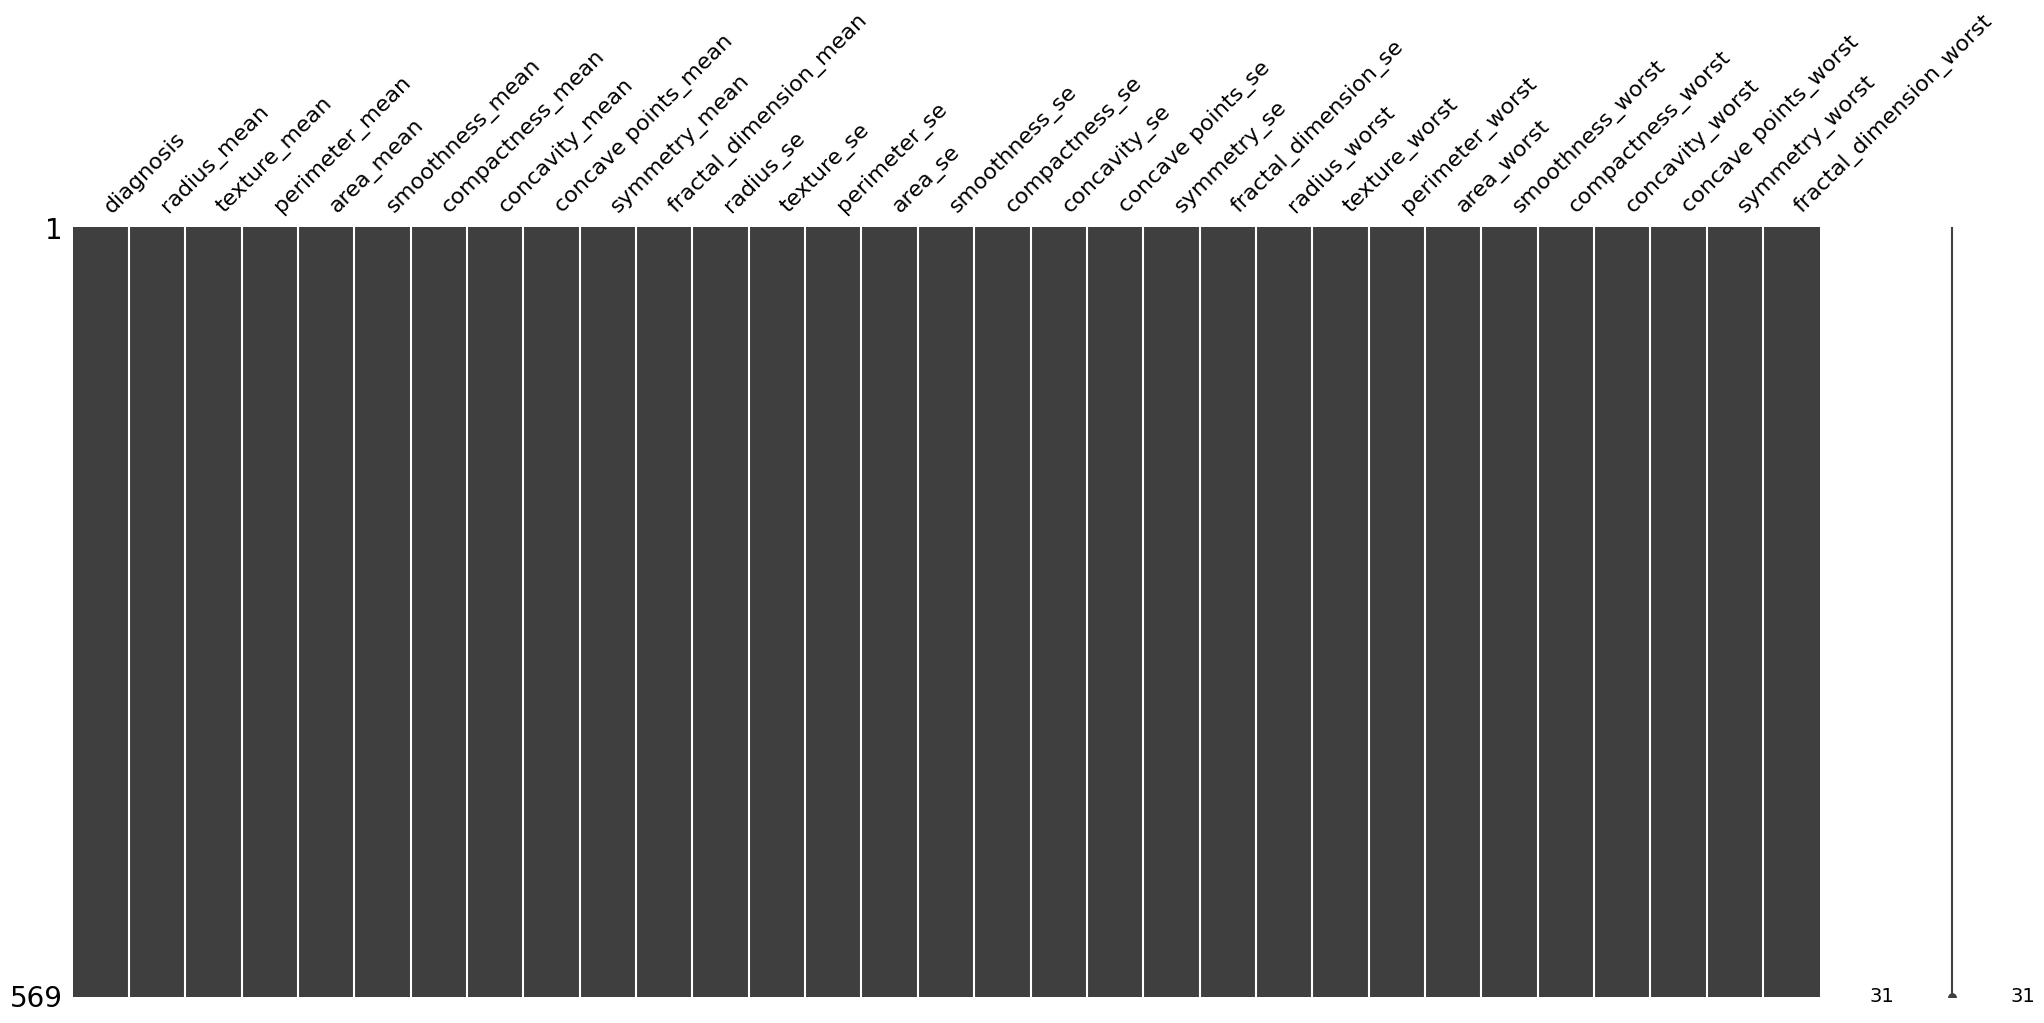

In [11]:
#!pip install missingno
import missingno as msno
msno.matrix(df_cleaned)

### Code - no missing values

In [12]:
#No missing values
df_nulls = df_cleaned.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
print(f'Missing values   {df_nulls.isna().sum().info()}') # empty
print(f'Number of missing values , per row in dataset : {df_nulls.shape[1]}') #No missing values


<class 'pandas.core.series.Series'>
Index: 0 entries
Series name: None
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 0.0+ bytes
Missing values   None
Number of missing values , per row in dataset : 0


As there is no need for treating missing values with either imputation techique , so let's save the final dataset ready for feature engineering and feature selection 

In [13]:
# Save cleaned data
df_cleaned.to_pickle('Final_Cancer_Data.pkl')